# This notebooks illustrates how to define a kinematic chain of a robot with forward and inverse kinematics


In [1]:
import numpy as np
import pytest
import os
import matplotlib.pyplot as plt

# jax is used so that the autograd can be used in the inverse kinematics
os.environ["GEOMETRICALGEBRA_NUMPY"] = "jax"  

from geometricalgebra import cga3d

from geometricalgebra.vector import ga_numpy

import jax
from jax import numpy as jnp
from jax.scipy.optimize import minimize

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
class Robot:
    """A planar robot with three links.

    The 3 degrees of freedom equal the 3D poses in 2D (2 degrees
    of freedom for the position and one for the orientation)
    """

    def __init__(self, link_lengths: tuple[float, float, float]):
        self._link_lengths = link_lengths

    def forward(self, joints: tuple[float, float, float], ret_links=False) -> cga3d.Vector:
        """Comupte the forward kinematics"""

        p = cga3d.Vector.from_identity()
        links = [p]
        for j, l in zip(joints, self._link_lengths):
            p = cga3d.Vector.from_rotator(j * cga3d.e_1 ^ cga3d.e_2) & p
            p = cga3d.Vector.from_translator(l * cga3d.e_1 ^ cga3d.e_inf) & p
            links.append(p.inverse())
        if ret_links:
            return cga3d.Vector.stack(links)
        return p.inverse()
    
    def _distance_to_goal_pose(self, joints, goal_pose) -> float:
        """Distance between the actual pose of the robot given the joints and a goal pose
        
        This difference is a sum of with the squared distance in position and a metric
        in orientation space
        """
        test_pose = self.forward(joints)
        a = test_pose.apply(cga3d.POSE_ORIGIN)
        b = goal_pose.apply(cga3d.POSE_ORIGIN)
        return - 2 * (a.scalar_product(b).sum()-3)
        
    def inverse(self, pose: cga3d.Vector, guess) -> tuple[float, float, float]:
        """Comupte the inverse kinematics"""
        result = minimize(
            self._distance_to_goal_pose,
            jnp.asarray(guess, dtype=float),
            method="BFGS",
            tol=1e-8,
            args=(goal_pose,)
        )
        if result.success and abs(result.fun) < 1e-8:
            return result.x
        raise ValueError("No solution found")
robot = Robot([1, 1, 1])

In [3]:


def show_tool(pose: cga3d.Vector):
    tool = cga3d.Vector.from_euclid([[-.5, -.5, 0], [0, -.5, 0], [0, .5, 0], [-.5, .5, 0]])
    tool_in_robot_frame = pose.apply(tool)
    plt.plot(*tool_in_robot_frame.to_euclid()[:, :2].T, '.-', marker='o')
    

def show_robot(links: cga3d.Vector):
    pos_joints = links.apply(cga3d.e_0).to_euclid()
    tool_pose = links[-1]
    plt.plot(*links.apply(cga3d.e_0).to_euclid()[:, :2].T, '.-', marker='o')
    show_tool(tool_pose)
    plt.xlim(-2.5, 2.5)
    plt.ylim(0, 5)
    plt.gca().set_aspect('equal')

pose: [ 0.86583703  1.89188842  0.          0.          0.         -3.        ]


/tmp/ipykernel_228954/3438846976.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(*links.apply(cga3d.e_0).to_euclid()[:, :2].T, '.-', marker='o')
/tmp/ipykernel_228954/3438846976.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(*tool_in_robot_frame.to_euclid()[:, :2].T, '.-', marker='o')


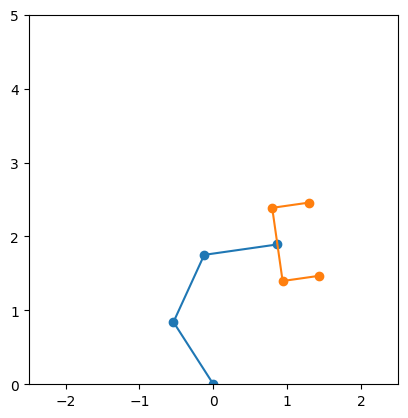

In [4]:
joints = [1, 1, 1]
pose = robot.forward(joints)
print(f"pose: {pose.to_pos_and_rot_vector()}")
show_robot(robot.forward(joints, ret_links=True))

joints: [1, 1, 1]


/tmp/ipykernel_228954/3438846976.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(*links.apply(cga3d.e_0).to_euclid()[:, :2].T, '.-', marker='o')
/tmp/ipykernel_228954/3438846976.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(*tool_in_robot_frame.to_euclid()[:, :2].T, '.-', marker='o')


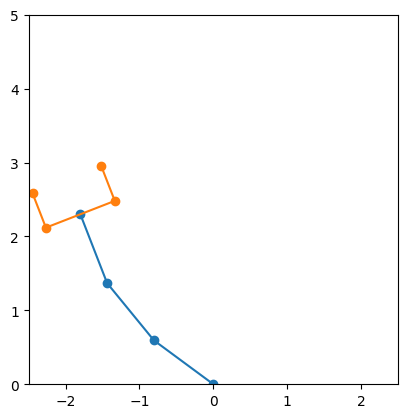

In [5]:
goal_pose = cga3d.Vector.from_pos_and_rot_vector([-1.8,  2.3,  0,  0,  0, -1.2])
joints_for_goal_pose = robot.inverse(goal_pose, joints)
print(f"joints: {joints}")
show_robot(robot.forward(joints_for_goal_pose, ret_links=True))